In [1]:
import os
os.chdir("/content/drive/My Drive/TF")

Importing Libraries

In [ ]:
# !pip install catboost
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow_hub as hub
import tensorflow as tf
import spacy
from transformers import BertTokenizer,TFBertModel,AutoTokenizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
from pandas.core.common import flatten
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold

In [ ]:
# NLTK Imports
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

Importing Datasets

In [3]:
train_df=pd.read_csv("train.csv")
val_df=pd.read_csv("validation.csv")
test_df=pd.read_csv("test.csv")

Exploring the Data

In [ ]:
train_df.head(10)

,screen_name,text,account.type,class_type
0,imranyebot,YEA now that note GOOD,bot,others
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn
5,dril,matrix 2: pedaphile killer,human,human
6,whalefakes,the world needs more whale stories. I would lo...,bot,gpt2
7,imranyebot,the tweet of time I don’t mean It’s got us fre...,bot,others
8,ninjasexparty,nobody:\r\n\r\nNSP: penis penis penis penis pe...,human,human
9,narendramodi,Had a wonderful interaction with leaders and M...,human,human


In [ ]:
train_df.describe()

,screen_name,text,account.type,class_type
count,20712,20712,20712,20712
unique,40,20712,2,4
top,kevinhooke,"""The more the files for run approach in a star...",human,human
freq,1951,1,10358,10358


In [ ]:
val_df.head(10)

,screen_name,text,account.type,class_type
0,ahadsheriff,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,human
1,narendramodi,India has millennia old relations with Oman. W...,human,human
2,jaden,Anxious Teenagers,human,human
3,JustinTrudeau,Our top priority is keeping Canadians safe. Wi...,human,human
4,imranyebot,nah bro You’re taking sis so much I’m just a g...,bot,others
5,zawarbot,its been giving rappers ever seen someone asks...,bot,others
6,dril_gpt2,unfollow if you're a nerd,bot,gpt2
7,dril_gpt2,"what if instead of spitting on me, you had ins...",bot,gpt2
8,imranyebot,NAH this one for BREAKFAST,bot,others
9,zawvrk,@jpkayy yo this is not a bad idea,human,human


Text(0.5, 1.0, 'Missing Values Heatmap')

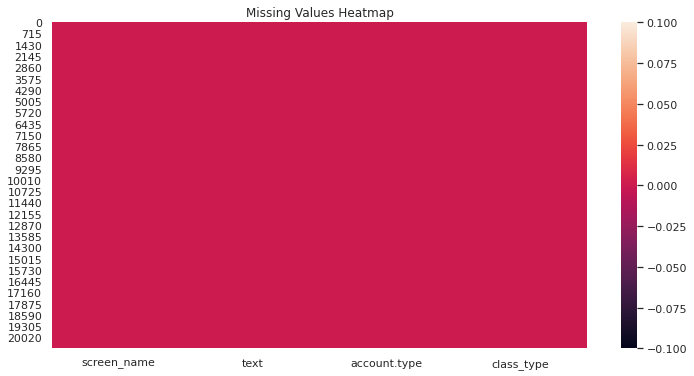

In [ ]:
# Checking the Missing Values
sns.set(rc={'figure.figsize':(12,6)})
sns.heatmap(train_df.isnull()).set_title("Missing Values Heatmap")

In [25]:
# Checking Data Distribution
def barplot_distribution(dataframe,column_name,title,width,height):    
  y=Counter(dataframe[column_name]).most_common(dataframe[column_name].nunique())
  category_names=[i[0] for i in y]
  category_count=[i[1] for i in y]
  sns.set(rc={'figure.figsize':(width,height)})
  sns.barplot(category_count,category_names).set_title(title)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


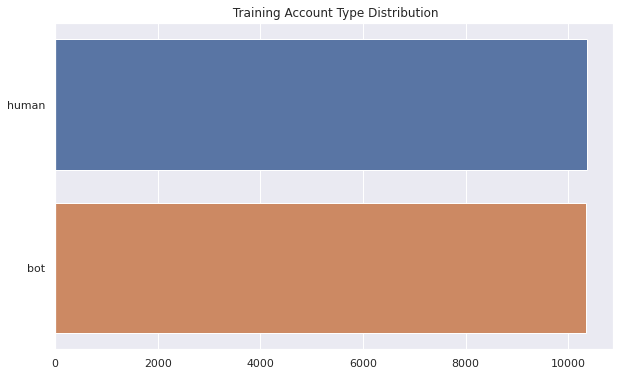

In [26]:
barplot_distribution(train_df,'account.type',' Training Account Type Distribution',10,6)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


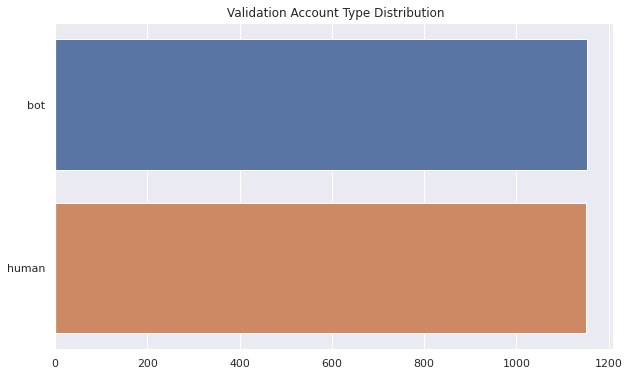

In [27]:
barplot_distribution(val_df,'account.type',' Validation Account Type Distribution',10,6)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


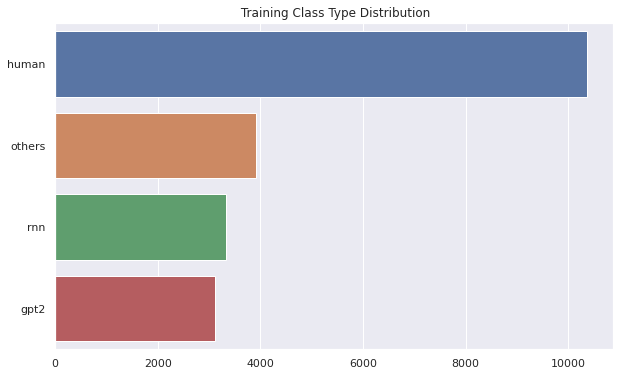

In [28]:
barplot_distribution(train_df,'class_type',' Training Class Type Distribution',10,6)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


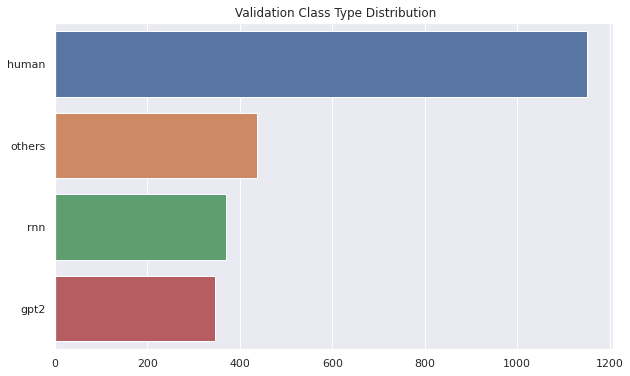

In [29]:
barplot_distribution(val_df,'class_type',' Validation Class Type Distribution',10,6)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


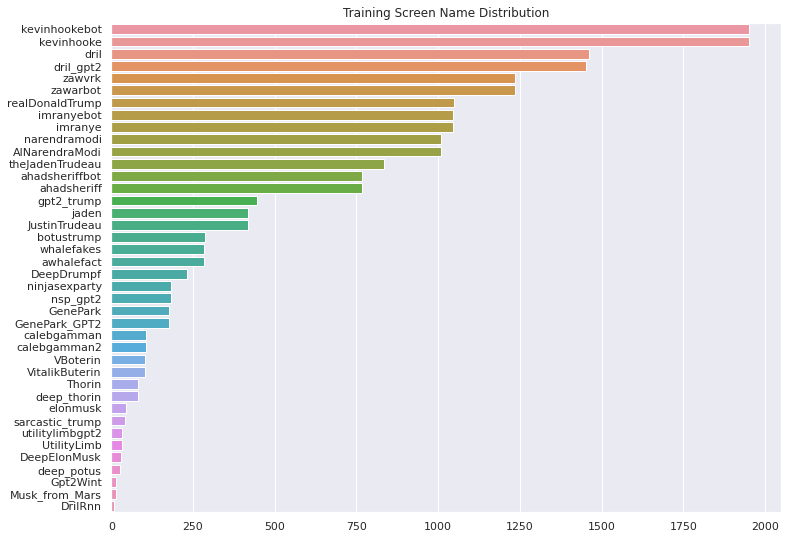

In [30]:
barplot_distribution(train_df,'screen_name','Training Screen Name Distribution',12,9)

In [57]:
def pieplot_distribution(dataframe,column_name,title,width,height,explode=None):    
  y=Counter(dataframe[column_name]).most_common(dataframe[column_name].nunique())
  category_names=[i[0] for i in y]
  category_count=[i[1] for i in y]
  plt.figure(figsize=(width,height))
  plt.pie(category_count,labels=category_names,shadow=True,explode=explode,autopct="%.2f",labeldistance=1.2)
  plt.title(title)
  plt.show()

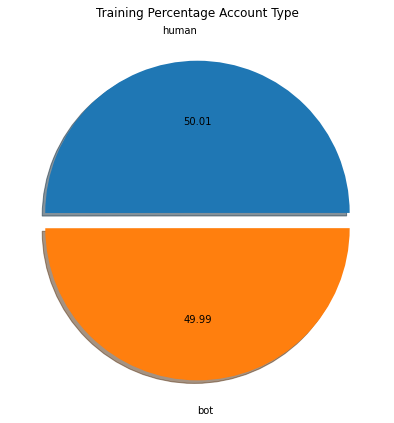

In [58]:
pieplot_distribution(train_df,'account.type','Training Percentage Account Type',12,7,explode=(0,0.1))

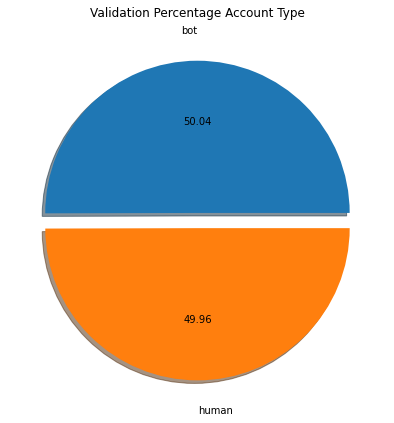

In [59]:
pieplot_distribution(val_df,'account.type','Validation Percentage Account Type',12,7,explode=(0,0.1))

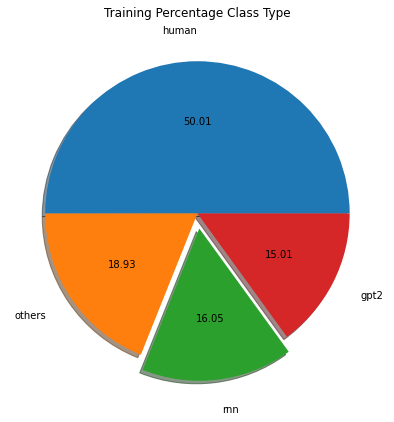

In [60]:
pieplot_distribution(train_df,'class_type','Training Percentage Class Type',12,7,explode=(0,0,0.1,0))

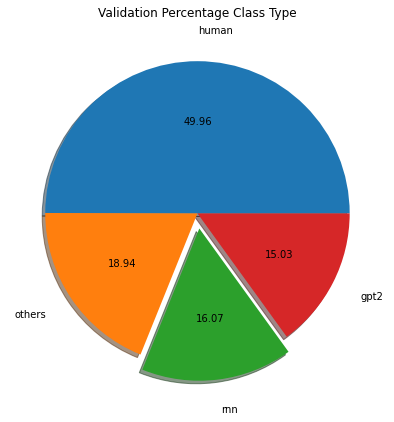

In [61]:
pieplot_distribution(val_df,'class_type','Validation Percentage Class Type',12,7,explode=(0,0,0.1,0))

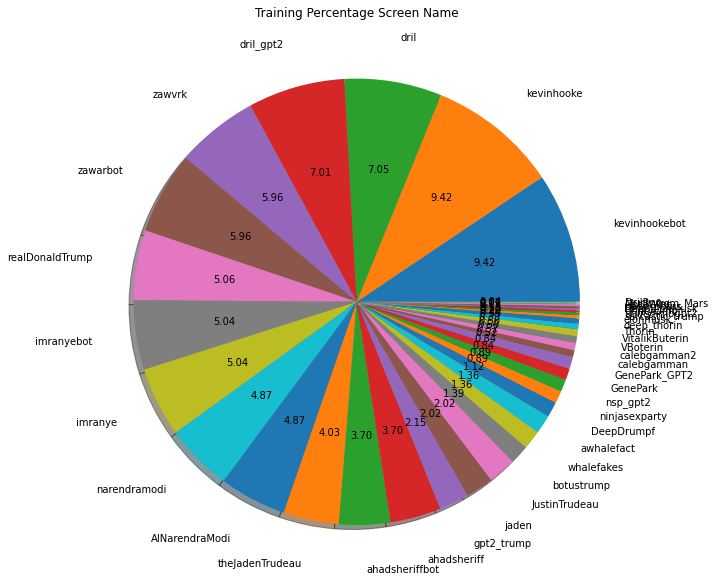

In [62]:
pieplot_distribution(train_df,'screen_name','Training Percentage Screen Name',10,20)

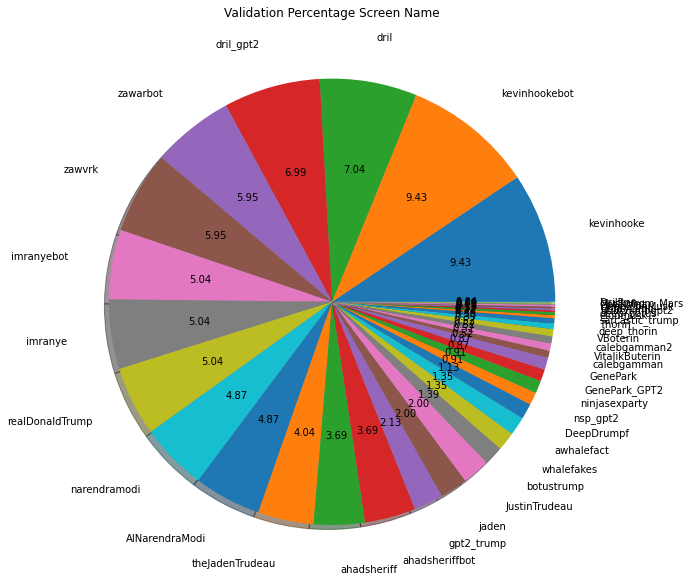

In [63]:
pieplot_distribution(val_df,'screen_name','Validation Percentage Screen Name',10,20)

In [ ]:
# def clean_text(text):
#   # URL Removal
#   text=re.sub(r"http\S+", " ",text)

#   # HTML Tags Removal
#   raw_html=re.compile('<.*?>')
#   text=re.sub(raw_html, ' ', text)

#   # Keeping only Alphabets
#   text=re.sub('[^a-zA-Z]+', ' ', text)

#   # # Text Lowering
#   # text=text.lower()

#   # Punctuation Removal
#   PUNCT_TO_REMOVE = string.punctuation
#   text=text.translate(str.maketrans('', '', PUNCT_TO_REMOVE)).strip()

#   return text

# # Text Cleaning    
# def clean_text(text):
#   # URL Removal
#   text=re.sub(r"http\S+", " ",text)

#   # HTML Tags Removal
#   raw_html=re.compile('<.*?>')
#   text=re.sub(raw_html, ' ', text)

#   # Keeping only Alphabets
#   text=re.sub('[^a-zA-Z]+', ' ', text)

#   # Text Lowering
#   text=text.lower()

#   # Punctuation Removal
#   PUNCT_TO_REMOVE = string.punctuation
#   text=text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

#   # StopWords Removal
#   STOPWORDS = set(stopwords.words('english'))

#   text=" ".join([word for word in str(text).split() if word not in STOPWORDS])

#   return text

# # Lemmatization
# def lemmatize_all(sentence):
#     lemmatized_words=[]
#     wnl = WordNetLemmatizer()

#     for word, tag in pos_tag(word_tokenize(sentence)):

#         if tag.startswith("NN"):

#             lemmatized_words.append(wnl.lemmatize(word, pos='n'))

#         elif tag.startswith('VB'):

#             lemmatized_words.append(wnl.lemmatize(word, pos='v'))

#         elif tag.startswith('JJ'):

#             lemmatized_words.append(wnl.lemmatize(word, pos='a'))

#         else:

#             lemmatized_words.append(word)

#     return ' '.join(lemmatized_words)

In [ ]:
# Cleaning Text
# train_df['cleaned_text']=train_df['text'].apply(lambda x:clean_text(x))
# val_df['cleaned_text']=val_df['text'].apply(lambda x:clean_text(x))
# test_df['cleaned_text']=test_df['text'].apply(lambda x:clean_text(x))


# # Cleaning Text
# train_df['cleaned_text']=train_df['text'].apply(lambda x:clean_text(x))
# val_df['cleaned_text']=val_df['text'].apply(lambda x:clean_text(x))
# test_df['cleaned_text']=test_df['text'].apply(lambda x:clean_text(x))

# # Lemmatization
# train_df['cleaned_text']=train_df['cleaned_text'].apply(lambda x:lemmatize_all(x))
# val_df['cleaned_text']=val_df['cleaned_text'].apply(lambda x:lemmatize_all(x))
# test_df['cleaned_text']=test_df['cleaned_text'].apply(lambda x:lemmatize_all(x))

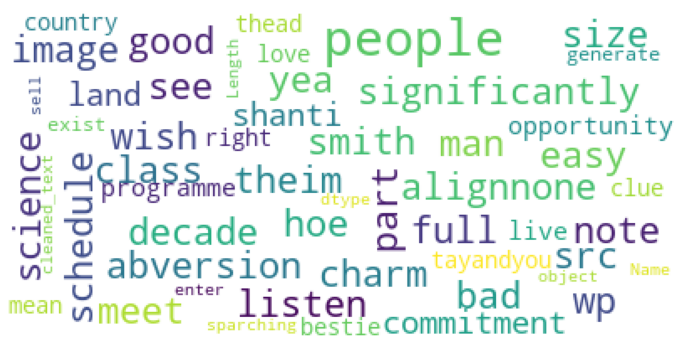

In [ ]:
# Checking the Most Frequent Words in Text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=1000,
                      max_font_size=30, 
                      random_state=42
                      ).generate(str(train_df['cleaned_text']))
print(wordcloud)
fig = plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
train_df.drop(columns=['screen_name'],inplace=True)
val_df.drop(columns=['screen_name'],inplace=True)
test_df.drop(columns=['screen_name'],inplace=True)

In [ ]:
val_df.head(10)

,text,account.type,class_type
0,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,human
1,India has millennia old relations with Oman. W...,human,human
2,Anxious Teenagers,human,human
3,Our top priority is keeping Canadians safe. Wi...,human,human
4,nah bro You’re taking sis so much I’m just a g...,bot,others
5,its been giving rappers ever seen someone asks...,bot,others
6,unfollow if you're a nerd,bot,gpt2
7,"what if instead of spitting on me, you had ins...",bot,gpt2
8,NAH this one for BREAKFAST,bot,others
9,@jpkayy yo this is not a bad idea,human,human


In [ ]:
train_df.head(10)

,text,account.type,class_type
0,YEA now that note GOOD,bot,others
1,Listen to This Charming Man by The Smiths htt...,human,human
2,wish i can i would be seeing other hoes on the...,bot,others
3,The decade in the significantly easier schedul...,bot,others
4,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn
5,matrix 2: pedaphile killer,human,human
6,the world needs more whale stories. I would lo...,bot,gpt2
7,the tweet of time I don’t mean It’s got us fre...,bot,others
8,nobody:\r\n\r\nNSP: penis penis penis penis pe...,human,human
9,Had a wonderful interaction with leaders and M...,human,human


In [ ]:
# Label Encoding the Target
label_encoder={'human':0,'bot':1}
train_df['account.type']=train_df['account.type'].replace(label_encoder)
val_df['account.type']=val_df['account.type'].replace(label_encoder)
test_df['account.type']=test_df['account.type'].replace(label_encoder)

In [ ]:
# Label Encoding Multiclass
encoder_multiclass={'human':0,'gpt2':1,'rnn':2,'others':3}
train_df['class_type']=train_df['class_type'].replace(encoder_multiclass)
val_df['class_type']=val_df['class_type'].replace(encoder_multiclass)
test_df['class_type']=test_df['class_type'].replace(encoder_multiclass)

In [ ]:
train_df.head(10)

,text,account.type,class_type
0,YEA now that note GOOD,1,3
1,Listen to This Charming Man by The Smiths htt...,0,0
2,wish i can i would be seeing other hoes on the...,1,3
3,The decade in the significantly easier schedul...,1,3
4,"""Theim class=\""alignnone size-full wp-image-60...",1,2
5,matrix 2: pedaphile killer,0,0
6,the world needs more whale stories. I would lo...,1,1
7,the tweet of time I don’t mean It’s got us fre...,1,3
8,nobody:\r\n\r\nNSP: penis penis penis penis pe...,0,0
9,Had a wonderful interaction with leaders and M...,0,0


Model Building Binary Classification

In [ ]:
# Model Constants
MAX_LENGTH=85
LR=0.001
BATCH_SIZE=16
EPOCHS=10

In [ ]:
# Preprocessing Data For Bert
tokenizer=BertTokenizer.from_pretrained("bert-base-cased",do_lower_case=False)
def tokenize(sentence,tokenizer,max_length):
  input_ids,attention_mask,token_type_ids=[],[],[]
  for sent in sentence:
    inputs=tokenizer.encode_plus(sent,max_length=max_length,add_special_tokens=True,pad_to_max_length=True,truncation=True)
    input_ids.append(inputs["input_ids"])
    attention_mask.append(inputs["attention_mask"])
    token_type_ids.append(inputs["token_type_ids"])

  return np.array(input_ids),np.array(attention_mask),np.array(token_type_ids)  

Text(0.5, 1.0, 'Sentence Length Distribution')

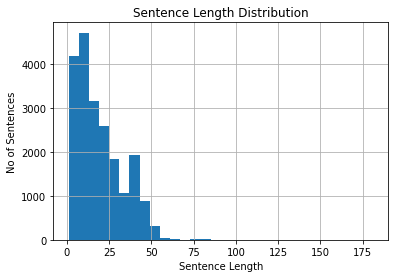

In [ ]:
# Checking the Max Sentence Length
seq_len=[len(i.split(" ")) for i in train_df.text]
pd.Series(seq_len).hist(bins = 30)
plt.xlabel("Sentence Length")
plt.ylabel("No of Sentences")
plt.title("Sentence Length Distribution")

In [ ]:
inputs_ids_train,attention_mask_train,token_type_ids_train=tokenize(train_df.text.values,tokenizer,85)

inputs_ids_val,attention_mask_val,token_type_ids_val=tokenize(val_df.text.values,tokenizer,85)

inputs_ids_test,attention_mask_test,token_type_ids_test=tokenize(test_df.text.values,tokenizer,85)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
def bert_binary():
    
  bert_encoder=TFBertModel.from_pretrained("bert-base-cased")

  for layer in bert_encoder.layers:
    layer.trainable=False

  input_ids=tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="input_word_ids")

  attention_mask_ids=tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="attention_mask_ids")

  token_type_ids=tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="token_type_ids")

  embeddings=bert_encoder([input_ids,attention_mask_ids,token_type_ids])[0]

  out=tf.keras.layers.Dense(1,activation='sigmoid')(embeddings[:,0,:])

  model=tf.keras.models.Model(inputs=[input_ids,attention_mask_ids,token_type_ids],outputs=out)

  return model

In [ ]:
# Compiling the Model
model=bert_binary()
opt=tf.keras.optimizers.Adam(lr=LR)
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=['accuracy'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Defining Model Callbacks
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=10,factor=0.6,min_lr=0.0000000001)
save_best=tf.keras.callbacks.ModelCheckpoint(filepath="model_binary.h5",monitor="val_loss",save_best_only=True,save_weights_only=True)
my_callbacks=[reduce_lr,save_best]

In [ ]:
# Fitting the Model
y_train=np.array(train_df["account.type"])
y_val=np.array(val_df["account.type"])
history=model.fit([inputs_ids_train,attention_mask_train,token_type_ids_train],
          y_train,validation_data=([inputs_ids_val,attention_mask_val,token_type_ids_val],y_val),
          epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=my_callbacks)

Epoch 1/10
1295/1295 [==============================] - 118s 91ms/step - loss: 0.4801 - accuracy: 0.7546 - val_loss: 0.4401 - val_accuracy: 0.7706
Epoch 2/10
1295/1295 [==============================] - 114s 88ms/step - loss: 0.4268 - accuracy: 0.7889 - val_loss: 0.4161 - val_accuracy: 0.8032
Epoch 3/10
1295/1295 [==============================] - 111s 85ms/step - loss: 0.4133 - accuracy: 0.7961 - val_loss: 0.4215 - val_accuracy: 0.7837
Epoch 4/10
1295/1295 [==============================] - 114s 88ms/step - loss: 0.4090 - accuracy: 0.8014 - val_loss: 0.4037 - val_accuracy: 0.8050
Epoch 5/10
1295/1295 [==============================] - 110s 85ms/step - loss: 0.4004 - accuracy: 0.8041 - val_loss: 0.4047 - val_accuracy: 0.7976
Epoch 6/10
1295/1295 [==============================] - 113s 87ms/step - loss: 0.3969 - accuracy: 0.8068 - val_loss: 0.3984 - val_accuracy: 0.8097
Epoch 7/10
1295/1295 [==============================] - 114s 88ms/step - loss: 0.3956 - accuracy: 0.8083 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


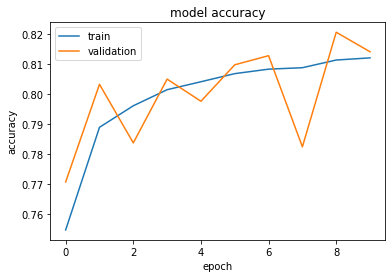

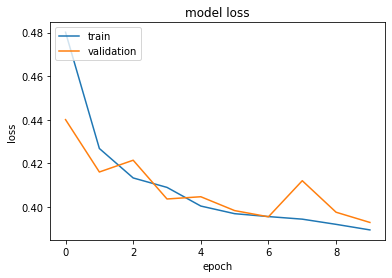

In [ ]:
# Accuracy and Loss Plot
print(history.history.keys())
 #"Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model=bert_binary()
model.load_weights("model_binary.h5")

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model Testing Phase

In [ ]:
y_pred_train=model.predict([inputs_ids_train,attention_mask_train,token_type_ids_train])
y_pred_train=np.where(y_pred_train>0.5,1,0).T[0]

y_pred_test=model.predict([inputs_ids_test,attention_mask_test,token_type_ids_test])
y_pred_test=np.where(y_pred_test>0.5,1,0).T[0]

In [ ]:
# Training Accuracy
print("Training Accuracy:{}".format(accuracy_score(y_train,y_pred_train)))

Training Accuracy:0.8246910003862495


In [ ]:
# Testing Accuracy
y_test=np.array(test_df["account.type"])
print("Testing Accuracy:{}".format(accuracy_score(y_test,y_pred_test)))

Testing Accuracy:0.8096168881939015


In [ ]:
# Training Classification Report
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83     10358
           1       0.84      0.81      0.82     10354

    accuracy                           0.82     20712
   macro avg       0.83      0.82      0.82     20712
weighted avg       0.83      0.82      0.82     20712



In [ ]:
# Testing Classification Report
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1278
           1       0.82      0.79      0.81      1280

    accuracy                           0.81      2558
   macro avg       0.81      0.81      0.81      2558
weighted avg       0.81      0.81      0.81      2558



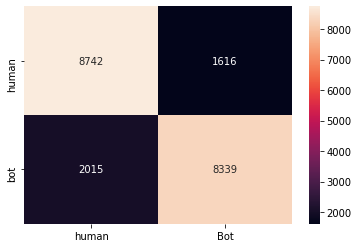

In [ ]:
# Training Confusion Matrix
cm=confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['human','Bot'],yticklabels=['human','bot'])

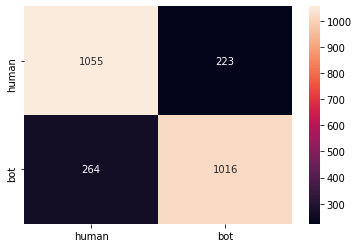

In [ ]:
# Testing Confusion Matrix
cm=confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['human','bot'],yticklabels=['human','bot'])

Model Building MultiClass Classification

In [ ]:
def bert_multiclass():
    
  bert_encoder=TFBertModel.from_pretrained("bert-base-cased")

  for layer in bert_encoder.layers:
    layer.trainable=False

  input_ids=tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="input_word_ids")

  attention_mask_ids=tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="attention_mask_ids")

  token_type_ids=tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="token_type_ids")

  embeddings=bert_encoder([input_ids,attention_mask_ids,token_type_ids])[0]

  out=tf.keras.layers.Dense(4,activation='softmax')(embeddings[:,0,:])

  model=tf.keras.models.Model(inputs=[input_ids,attention_mask_ids,token_type_ids],outputs=out)

  return model

In [ ]:
# Compiling the Model
model=bert_multiclass()
opt=tf.keras.optimizers.Adam(lr=LR)
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=['categorical_accuracy'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Defining Model Callbacks
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=10,factor=0.6,min_lr=0.0000000001)
save_best=tf.keras.callbacks.ModelCheckpoint(filepath="model_multiclass.h5",monitor="val_loss",save_best_only=True,save_weights_only=True)
my_callbacks=[reduce_lr,save_best]

In [ ]:
# Fitting the Model
y_train=np.array(train_df["class_type"])
y_val=np.array(val_df["class_type"])
y_test=np.array(test_df["class_type"])

train_y=to_categorical(y_train)
val_y=to_categorical(y_val)

history=model.fit([inputs_ids_train,attention_mask_train,token_type_ids_train],
          train_y,validation_data=([inputs_ids_val,attention_mask_val,token_type_ids_val],val_y),
          epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=my_callbacks)

Epoch 1/10
1295/1295 [==============================] - 118s 91ms/step - loss: 0.6988 - categorical_accuracy: 0.7185 - val_loss: 0.5751 - val_categorical_accuracy: 0.7472
Epoch 2/10
1295/1295 [==============================] - 113s 87ms/step - loss: 0.5575 - categorical_accuracy: 0.7735 - val_loss: 0.5223 - val_categorical_accuracy: 0.7780
Epoch 3/10
1295/1295 [==============================] - 112s 87ms/step - loss: 0.5279 - categorical_accuracy: 0.7811 - val_loss: 0.5083 - val_categorical_accuracy: 0.7924
Epoch 4/10
1295/1295 [==============================] - 113s 87ms/step - loss: 0.5066 - categorical_accuracy: 0.7918 - val_loss: 0.4882 - val_categorical_accuracy: 0.8032
Epoch 5/10
1295/1295 [==============================] - 113s 87ms/step - loss: 0.5002 - categorical_accuracy: 0.7939 - val_loss: 0.4812 - val_categorical_accuracy: 0.8041
Epoch 6/10
1295/1295 [==============================] - 114s 88ms/step - loss: 0.4924 - categorical_accuracy: 0.7959 - val_loss: 0.4729 - val_cat

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


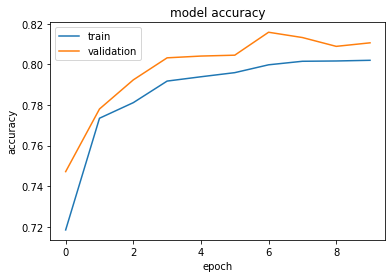

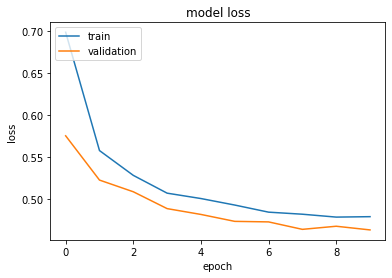

In [ ]:
# Accuracy and Loss Plot
print(history.history.keys())
 #"Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Model Testing Phase

In [ ]:
y_pred_train=model.predict([inputs_ids_train,attention_mask_train,token_type_ids_train])
y_pred_train=np.argmax(y_pred_train,axis=1)

y_pred_test=model.predict([inputs_ids_test,attention_mask_test,token_type_ids_test])
y_pred_test=np.argmax(y_pred_test,axis=1)

In [ ]:
# Training Accuracy
print("Training Accuracy:{}".format(accuracy_score(y_train,y_pred_train)))

Training Accuracy:0.8309675550405562


In [ ]:
# Testing Accuracy
print("Testing Accuracy:{}".format(accuracy_score(y_test,y_pred_test)))

Testing Accuracy:0.8068803752931978


In [ ]:
# Training Classification Report
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85     10358
           1       0.62      0.69      0.65      3109
           2       0.95      0.91      0.93      3325
           3       0.83      0.87      0.85      3920

    accuracy                           0.83     20712
   macro avg       0.82      0.83      0.82     20712
weighted avg       0.84      0.83      0.83     20712



In [ ]:
# Testing Classification Report
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1278
           1       0.57      0.65      0.61       384
           2       0.95      0.90      0.93       412
           3       0.78      0.83      0.81       484

    accuracy                           0.81      2558
   macro avg       0.79      0.80      0.79      2558
weighted avg       0.82      0.81      0.81      2558



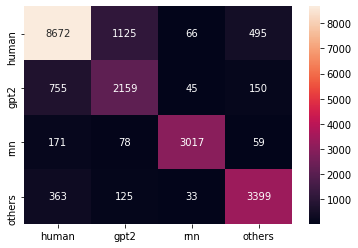

In [ ]:
# Training Confusion Matrix
cm=confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['human','gpt2','rnn','others'],yticklabels=['human','gpt2','rnn','others'])

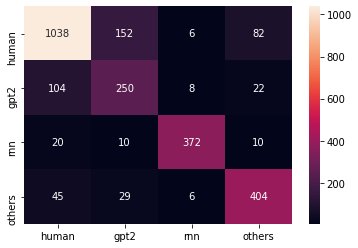

In [ ]:
cm=confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['human','gpt2','rnn','others'],yticklabels=['human','gpt2','rnn','others'])

In [ ]:
# matrix = TfidfVectorizer(max_features=3000,ngram_range=(1,2))
# # Train
# X_train = pd.DataFrame(matrix.fit_transform(train_df.cleaned_text).toarray(),columns=matrix.get_feature_names())
# y_train=train_df["account.type"]

# # Validation
# X_val = pd.DataFrame(matrix.transform(val_df.cleaned_text).toarray(),columns=matrix.get_feature_names())
# y_val=val_df["account.type"]

# # Test
# X_test = pd.DataFrame(matrix.transform(test_df.cleaned_text).toarray(),columns=matrix.get_feature_names())
# y_test=test_df["account.type"]

In [ ]:
# # Universal Sentence Encoder
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
# embed = hub.load(module_url)

In [ ]:
# training_embeddings = embed(train_df.cleaned_text.to_list())
# validation_embeddings = embed(val_df.cleaned_text.to_list())
# testing_embeddings = embed(test_df.cleaned_text.to_list())

In [ ]:
# training_embeddings =np.array(training_embeddings) 
# validation_embeddings =np.array(validation_embeddings) 
# testing_embeddings = np.array(testing_embeddings)

In [ ]:
# Fitting the Classifier
# classifier=LogisticRegression()
# classifier.fit(training_embeddings,y_train)
# model = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5, depth=10, rsm=0.98, loss_function= 'Logloss', eval_metric='Accuracy',use_best_model=True,random_seed=42)
# model.fit(training_embeddings,y_train,eval_set=(validation_embeddings,y_val))

In [ ]:
# from collections import Counter
# def get_pos(string):
#     string = nltk.word_tokenize(string)
#     tags = nltk.pos_tag(string)     
#     tags=[x[1] for x in tags]
#     tags=[tag for tag in tags if tag in ('NN', 'VB','JJ')]
#     tags=Counter(tags)
#     return tags

In [ ]:
# pos_train=train_df["cleaned_text"].apply(lambda x:get_pos(x))
# pos_test=test_df["cleaned_text"].apply(lambda x:get_pos(x))
# pos_valid=val_df["cleaned_text"].apply(lambda x:get_pos(x))

In [ ]:
# train_features = pd.DataFrame(list(pos_train)).set_index(pos_train.index)
# train_features.fillna(0,inplace=True)

# valid_features = pd.DataFrame(list(pos_valid)).set_index(pos_valid.index)
# valid_features.fillna(0,inplace=True)

# test_features = pd.DataFrame(list(pos_test)).set_index(pos_test.index)
# test_features.fillna(0,inplace=True)

# word_count_train=[len(i.split(" ")) for i in train_df.cleaned_text]


# word_count_test=[len(i.split(" ")) for i in test_df.cleaned_text]

# word_count_valid=[len(i.split(" ")) for i in val_df.cleaned_text]

# train_features['Word Count']=word_count_train
# test_features['Word Count']=word_count_test
# valid_features['Word Count']=word_count_valid

In [ ]:
# cols = list(train_features.columns.values)

In [ ]:
# valid_features=valid_features[cols]

In [ ]:
# valid_features

In [ ]:
# train_features

In [ ]:
# model = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5, depth=10, rsm=0.98, loss_function= 'Logloss', eval_metric='Accuracy',use_best_model=True,random_seed=42)
# model.fit(train_features,train_df["account.type"],eval_set=(valid_features,val_df["account.type"]))

# classifier=RandomForestClassifier(max_depth=12,n_estimators=800)
# classifier.fit(train_features,train_df["account.type"])

In [ ]:
# # Training Accuracy
# y_pred_train=model.predict(train_features)
# print("Training Accuracy:{}".format(accuracy_score(train_df["account.type"],y_pred_train)))

In [ ]:
# # Testing Accuracy
# y_pred_test=model.predict(test_features)
# print("Testing Accuracy:{}".format(accuracy_score(test_df["account.type"],y_pred_test)))